In [1]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import scltnn #非必需
print('scltnn(Ver): ',scltnn.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
from scipy import sparse

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
scltnn(Ver):  0.0.8
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.4
pandas(Ver):  1.4.3
scvelo(Ver):  0.2.4
Pyomic(Ver):  1.1.6


In [2]:
#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
sc_color=['#7CBB5F',
 '#368650',
 '#A499CC',
 '#5E4D9A',
 '#78C2ED',
 '#866017',
 '#9F987F',
 '#E0DFED',
 '#EF7B77',
 '#279AD7',
 '#F0EEF0',
 '#1F577B',
 '#A56BA7',
 '#E0A7C8',
 '#E069A6',
 '#941456',
 '#FCBC10',
 '#EAEFC5',
 '#01A0A7',
 '#75C8CC',
 '#F0D7BC',
 '#D5B26C',
 '#D5DA48',
 '#B6B812',
 '#9DC3C3',
 '#A89C92',
 '#FEE00C',
 '#FEF2A1']

In [12]:
import os
import collections
import tables
import h5py
import scipy.io
import csv
import gzip
import scipy.sparse as sp_sparse
import argparse as ap
import pandas as pd
FeatureBCMatrix = collections.namedtuple('FeatureBCMatrix', ['ids', 'names', 'barcodes', 'matrix'])
def read_10X_h5(filename):
    """Read 10X HDF5 files, support both gene expression and peaks."""
    with tables.open_file(filename, 'r') as f:
        try:
            group = f.get_node(f.root, 'matrix')
        except tables.NoSuchNodeError:
            print("Matrix group does not exist in this file.")
            return None
        feature_group = getattr(group, 'features')
        ids = getattr(feature_group, 'id').read()
        names = getattr(feature_group, 'name').read()
        barcodes = getattr(group, 'barcodes').read()
        data = getattr(group, 'data').read()
        indices = getattr(group, 'indices').read()
        indptr = getattr(group, 'indptr').read()
        shape = getattr(group, 'shape').read()
        matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)
        return FeatureBCMatrix(ids, names, barcodes, matrix)

In [98]:
import re
scatac_count=read_10X_h5('../data/raw_data/brca_atac_act_gene_score.h5')
peakmatrix = scatac_count.matrix
features = scatac_count.names.tolist()
features = [re.sub("\W", "_", feature.decode()) for feature in features]
features = [feature.encode() for feature in features]
barcodes = scatac_count.barcodes.tolist()

In [99]:
adata=anndata.AnnData(peakmatrix.T,obs=barcodes,var=features)
adata

AnnData object with n_obs × n_vars = 12844 × 28307
    obs: 0
    var: 0

In [100]:
adata.obs.index=[i.decode('utf-8') for i in adata.obs[0]]
adata.var.index=[i.decode('utf-8') for i in adata.var[0]]
del adata.obs[0]
del adata.var[0]

In [101]:
adata

AnnData object with n_obs × n_vars = 12844 × 28307

In [29]:
#adata=sc.read('../data/raw_data/atac_activity.h5ad')
import scanpy as sc
atac=sc.read('../glue_true/atac-emb.h5ad')
#adata=adata.raw.to_adata()
atac

AnnData object with n_obs × n_vars = 12844 × 71272
    obs: 'Type', 'domain'
    var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
    uns: 'Type_colors', 'neighbors', 'umap'
    obsm: 'X_glue', 'X_lsi', 'X_umap'
    varm: 'X_glue'
    obsp: 'connectivities', 'distances'

In [104]:
adata.obs=atac.obs
adata.obsm=atac.obsm
adata.obsp=atac.obsp
adata.uns=atac.uns
adata

AnnData object with n_obs × n_vars = 12844 × 28307
    obs: 'Type', 'domain', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    uns: 'Type_colors', 'neighbors', 'umap'
    obsm: 'X_glue', 'X_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [102]:
test=adata.X.copy().toarray()
test[np.isnan(test)] = 0.0
test=sparse.csr_matrix(test)
test

<12844x28307 sparse matrix of type '<class 'numpy.float32'>'
	with 132391923 stored elements in Compressed Sparse Row format>

In [105]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

In [106]:
adata.X=test
adata.X.min(),adata.X.max()

(-117.69784, 405.74442)

In [147]:
test

<12844x28307 sparse matrix of type '<class 'numpy.float32'>'
	with 132391923 stored elements in Compressed Sparse Row format>

In [108]:
adata.write_h5ad('../data/raw_data/brca_atac_act.h5ad',compression='gzip')

In [185]:
adata=sc.read('../data/raw_data/brca_atac_act.h5ad')
adata

AnnData object with n_obs × n_vars = 12844 × 28307
    obs: 'Type', 'domain', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    uns: 'Type_colors', 'neighbors', 'umap'
    obsm: 'X_glue', 'X_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [186]:
adata.X.min(),adata.X.max()

(-117.69784, 405.74442)

In [187]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

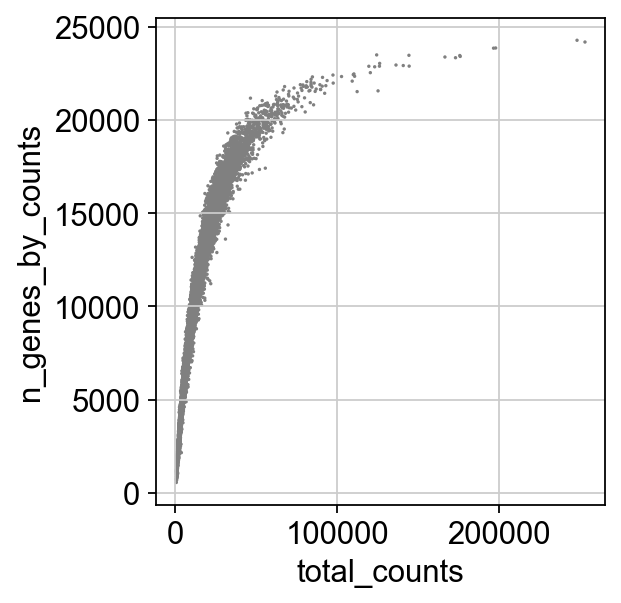

In [188]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [189]:
#归一化，我们发现total_counts的最大计数为20000，也就是说数量级为10e4
adata.raw=adata
sc.pp.normalize_total(adata)

normalizing counts per cell
    finished (0:00:00)


In [190]:
adata.X.min(),adata.X.max()

(-5.5053167, 496.22665)

In [191]:
#对数化：缩小数据的绝对数值，方便计算。
sc.pp.log1p(adata)

In [167]:
adata.var.max()

mt                             False
n_cells_by_counts              12028
mean_counts                22.637316
pct_dropout_by_counts          100.0
total_counts             290753.3125
dtype: object

In [10]:
#保存数据并过滤
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [192]:
#将每个基因按单位方差缩放。剪辑值超过标准差10。
sc.pp.scale(adata, max_value=10)
adata.X.min(),adata.X.max()

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(nan, nan)

In [193]:
test=adata.X
test[np.isnan(test)] = 0.0
#test=sparse.csr_matrix(test)
adata.X=test

In [194]:
adata.X.min(),adata.X.max()

(-2.050883, 10.0)

In [195]:
sc.tl.pca(adata, n_comps=100, svd_solver="arpack")
sc.pp.neighbors(adata, use_rep="X_glue", metric="cosine",n_neighbors=15, random_state = 112)
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata,init_pos='paga')


computing PCA
    with n_comps=100
    finished (0:00:26)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


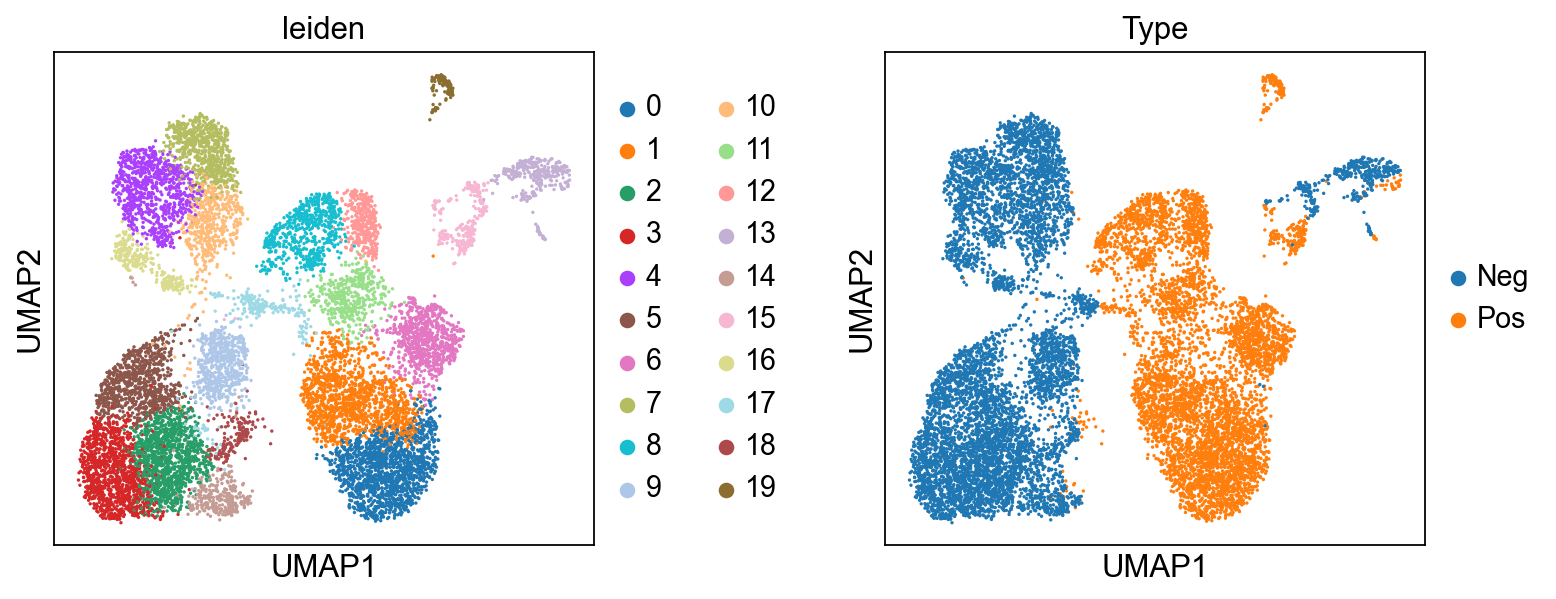

In [196]:
sc.pl.umap(adata,color=['leiden','Type'],wspace=0.4)

In [197]:
marker_genes_dict = {
    'Epitheilial': ['EPCAM'],
    'Proliferating': ['MKI67'],
    'T-cell': ['CD3D'],
    'Myeloid':['CD68'],
    'B-cell':['MS4A1'],
    'plasmablasts':['JCHAIN'],
    'Endothelial':['PECAM1'],
    #'Mesenchymal':['PDGFRB']
}

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Epitheilial, Proliferating, T-cell, etc.


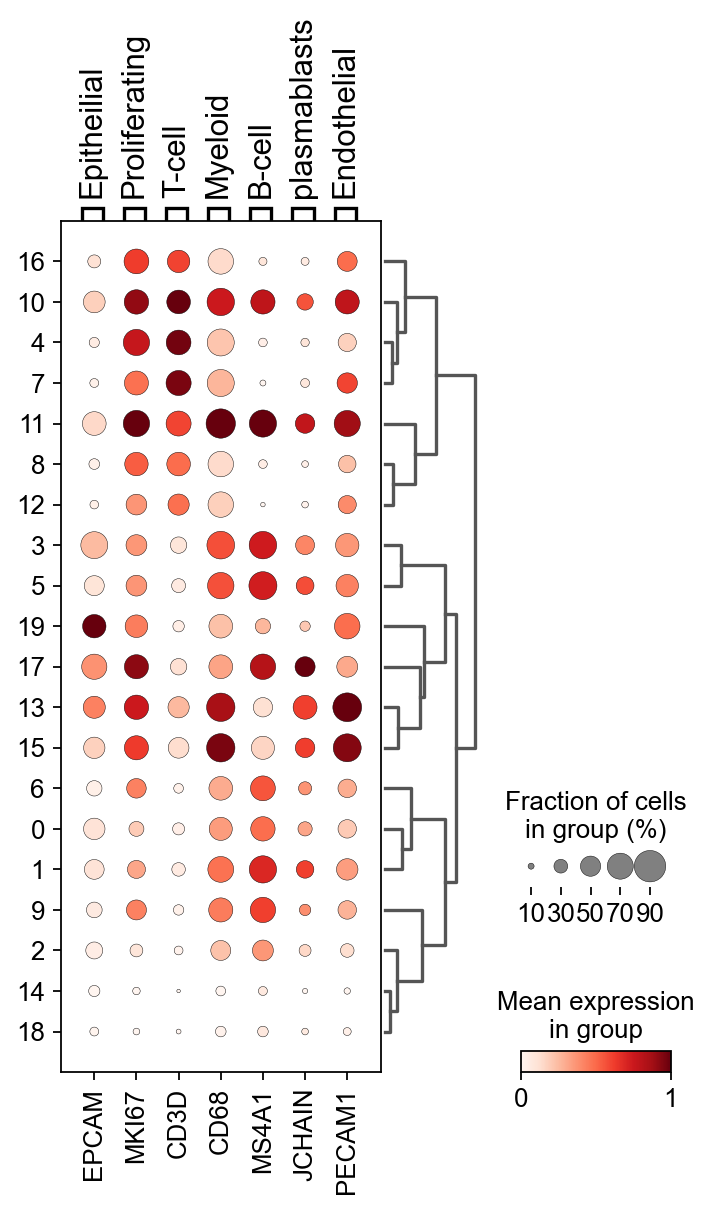

In [198]:
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, marker_genes_dict, 'leiden', dendrogram=True,standard_scale='var')

In [178]:
#'CD163', 'CLEC10A', 'CLEC9A', 'GNLY', 'S100A12', 'S100A8', 'TPSAB1', 'VCAM1'
res_marker_dict={
    'Tumor':['NDUFA4L2','BIRC3','RASSF4'],
    'Mesangial cell':['ACTA2'],
    'Endothelium(VCAM1-)':['PTPRB','PECAM1'],
    #'Endothelium(VCAM1+)':['VCAM1'],
    'Mast cell':['KIT'],
    'Neutrophil' :['CXCL8','FCGR3B'],
    'Dendritic cell':['CD1C','IDO1'],
    'Monocyte' :['S100A9','FCGR3A','LST1','LILRB2'],
    'Macrophage':['CSF1R','CD68'],
    'B cell':['MS4A1','CD79A','MZB1','JCHAIN'],
    'Proliferative CD8+ T cell':['MKI67','TOP2A','STMN1'],
    'NK/NKT cell':['KLRD1'],
    'CD8+T cell':['CD8A','CD8B'],
    'Treg':['CD4','CD40LG','IL7R','FOXP3','IL2RA'],
    'CD4+T cell':['PTPRC','CD3D','CD3E'],
}


    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Tumor, Mesangial cell, Endothelium(VCAM1-), etc.


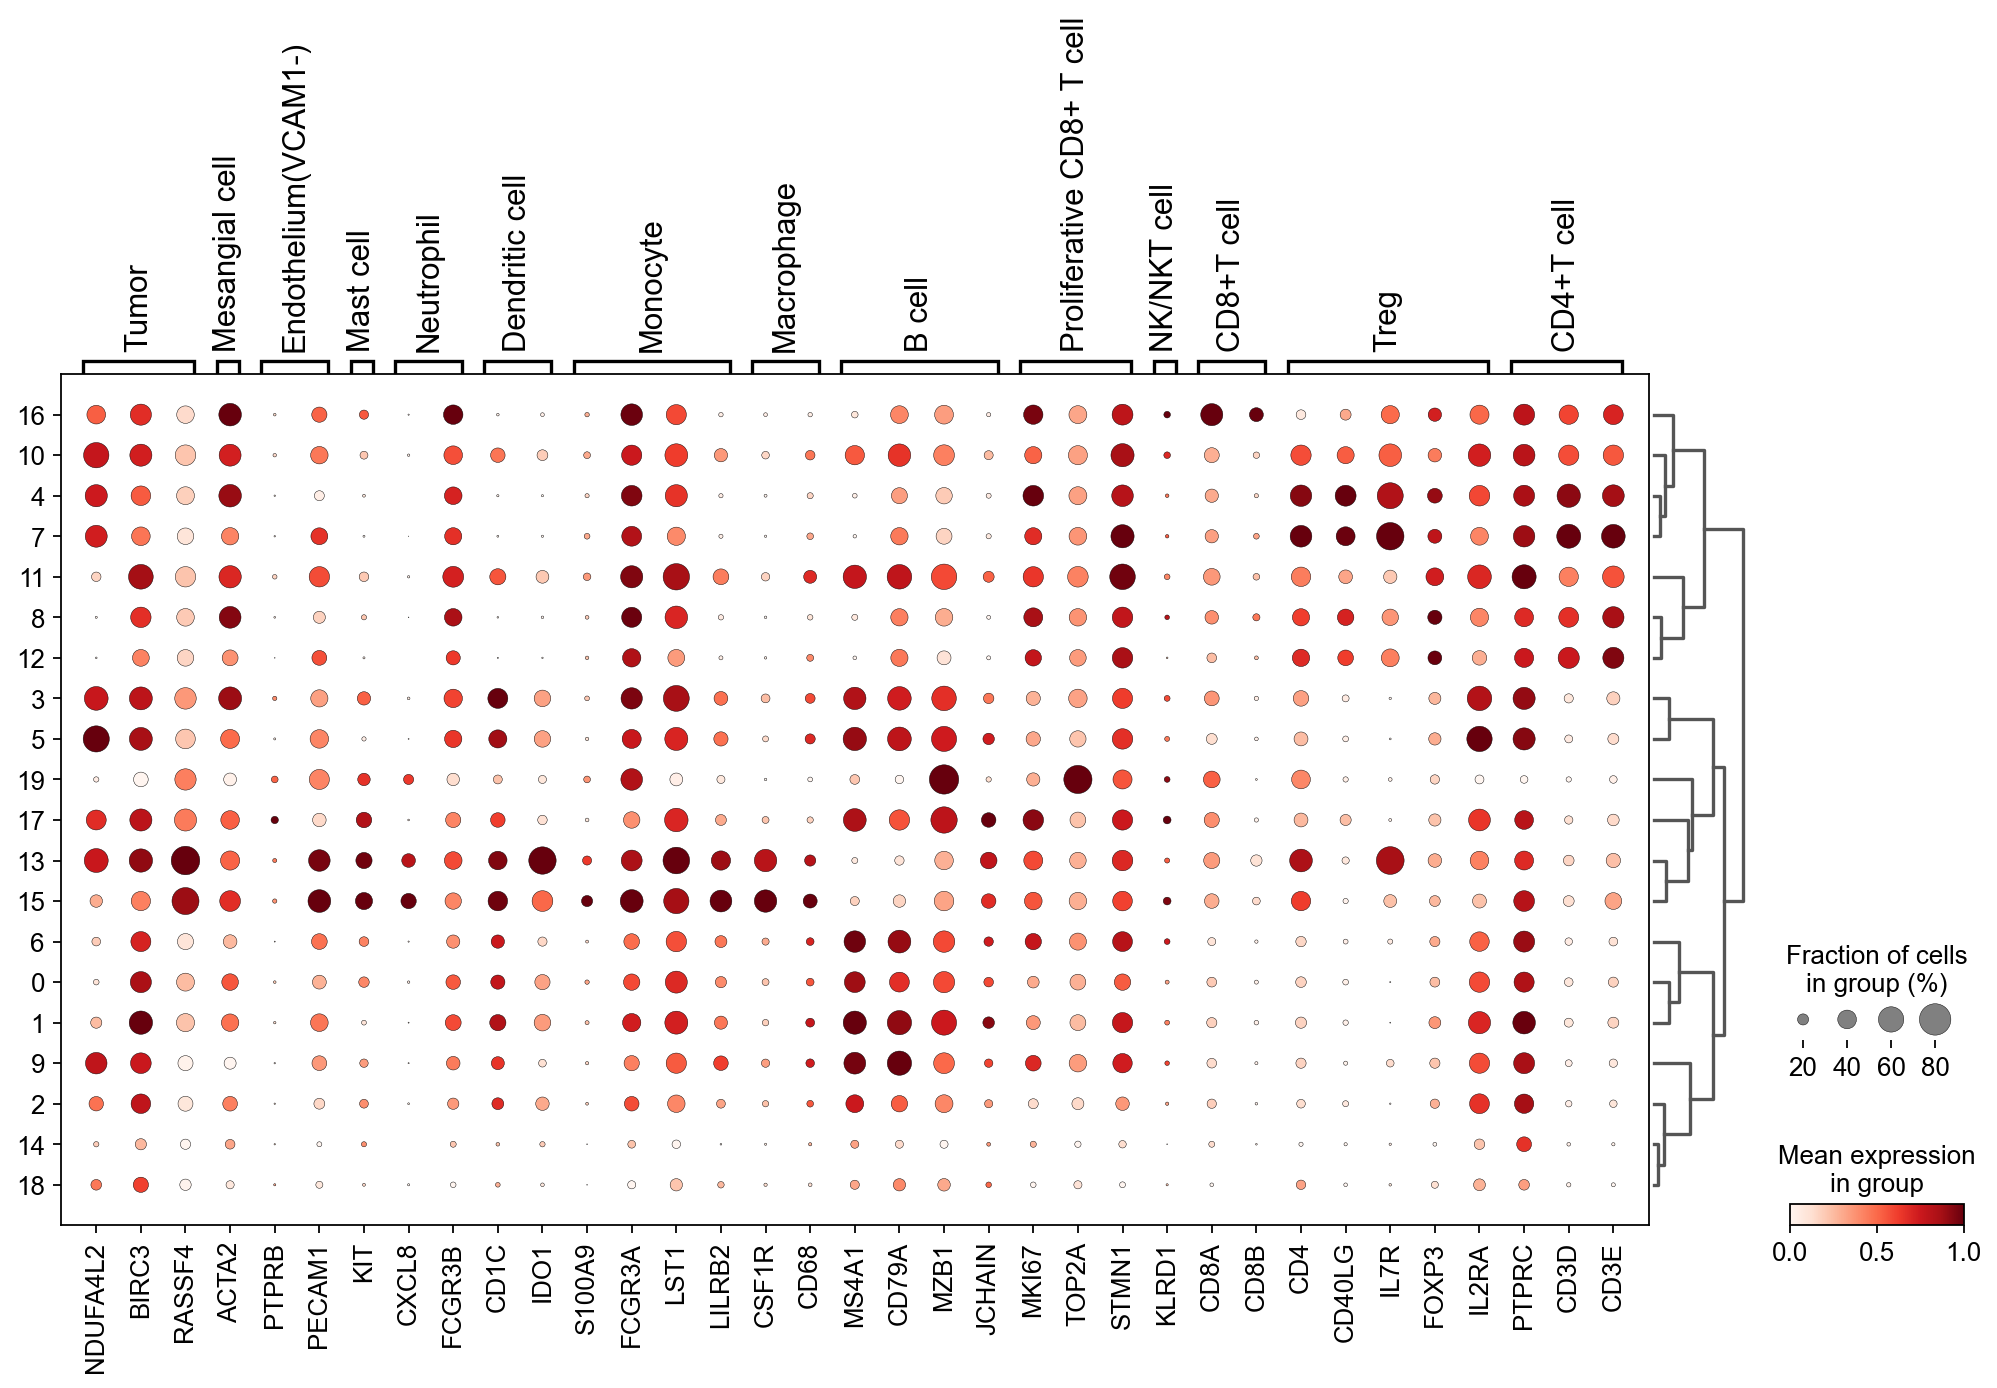

In [179]:
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, res_marker_dict, 'leiden', dendrogram=True,standard_scale='var')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


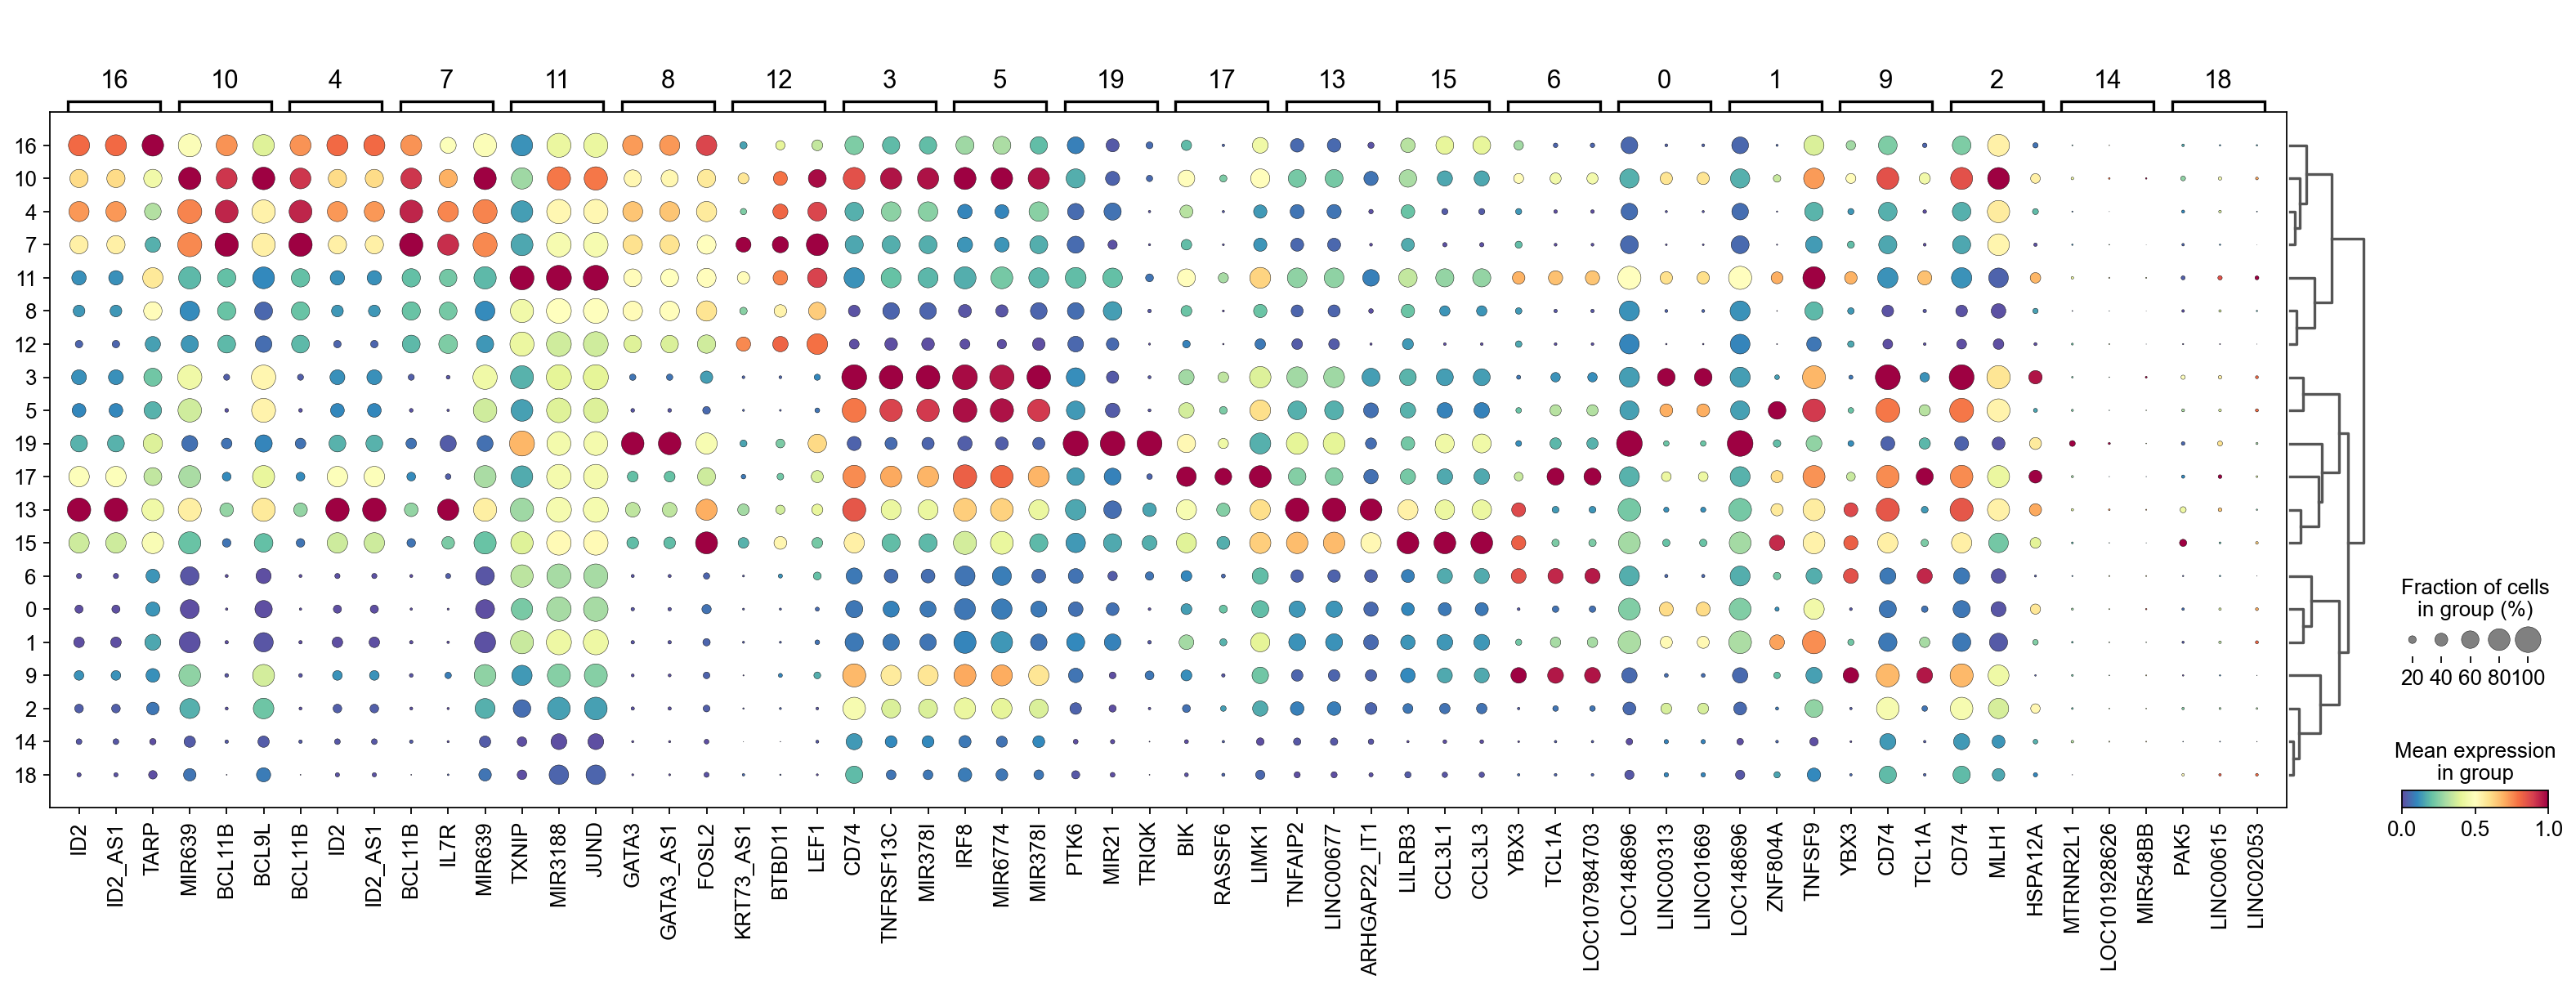

In [199]:
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',
                                standard_scale='var',n_genes=3)

In [200]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'B-cell',
     '1': 'B-cell',
     '2': 'B-cell',#Germ-cell(Oid)
     '3': 'B-cell',#Germ-cell(Oid)
     '4': 'T-cell',
     '5': 'B-cell',
     '6': 'B-cell',
     '7': 'T-cell',
     '8': 'T-cell',
     '9': 'B-cell',
     '10': 'T-cell',#Germ-cell(Oid)
     '11': 'T-cell',
     '12': 'T-cell',
     '13': 'Tumor',
     '14': 'B-cell',
     '15': 'Macrophage/NEUT',#Germ
     '16': 'T-cell',#plasma
     '17': 'B-cell',#plasma
     '18': 'B-cell',#plasma
     '19': 'Epithelial',#plasma

}
adata.obs['major_celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [201]:
type_color_atac={
    'B-cell':sc_color[12],
    'T-cell':sc_color[15],
    'Epithelial':sc_color[18],
    'NK/NKT-cell':sc_color[26],
    'Tumor':sc_color[9],
    'Macrophage/NEUT':sc_color[1],
}
adata.uns['major_celltype_colors']=adata.obs['major_celltype'].cat.categories.map(type_color_atac).values.tolist()

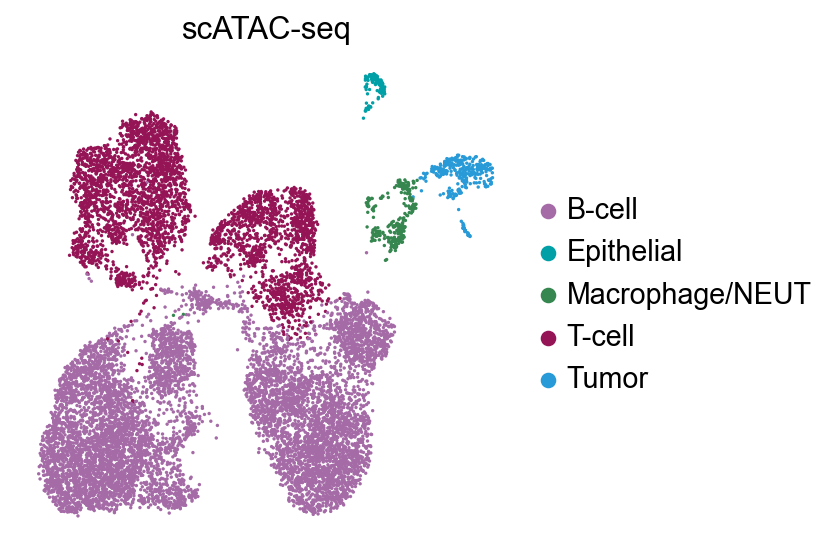

In [202]:
#pp=plt.figure(figsize=(4,4))
#用ax控制图片
#ax=pp.add_subplot(1,1,1)
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color='major_celltype',
    title='scATAC-seq',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    show=False,
)
plt.savefig("figure1_celltype_scatac.png",dpi=300,bbox_inches = 'tight')

In [203]:
adata.write_h5ad('atac_gs_anno.h5ad',compression='gzip')

In [184]:
rna=sc.read('rna_anno.h5ad')

In [58]:
rna.obs['domain']='scRNA-seq'
rna.obs['new_leiden']=[i+'-rna' for i in rna.obs['leiden']]
rna.obs['new_celltype']=[i+'-rna' for i in rna.obs['major_celltype']]
adata.obs['domain']='scATAC-seq'
adata.obs['new_leiden']=[i+'-atac' for i in adata.obs['leiden']]
adata.obs['new_celltype']=[i+'-atac' for i in adata.obs['major_celltype']]

In [59]:
combined = anndata.concat([rna, adata])

In [60]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


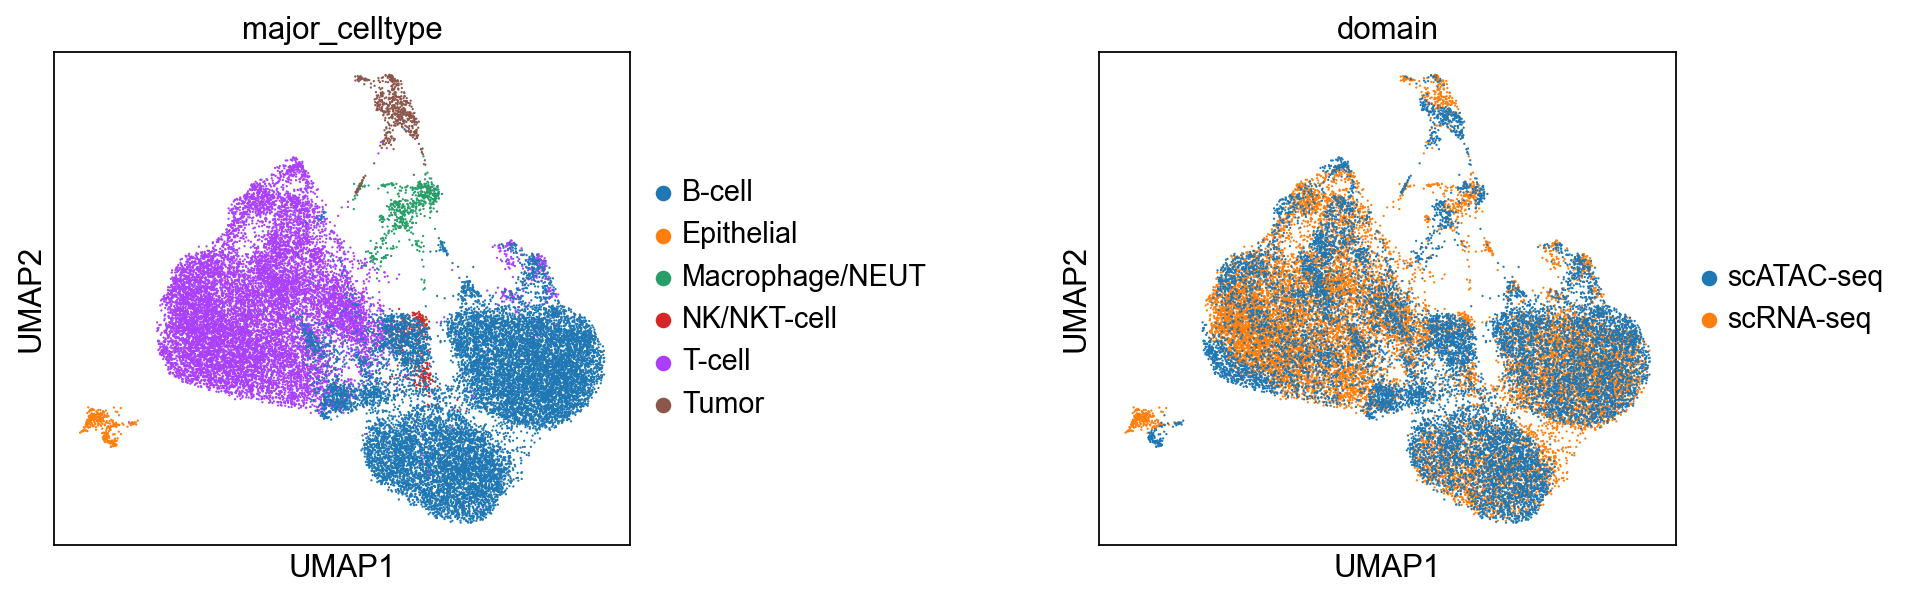

In [61]:
sc.pl.umap(combined, color=["major_celltype","domain"], wspace=0.65)

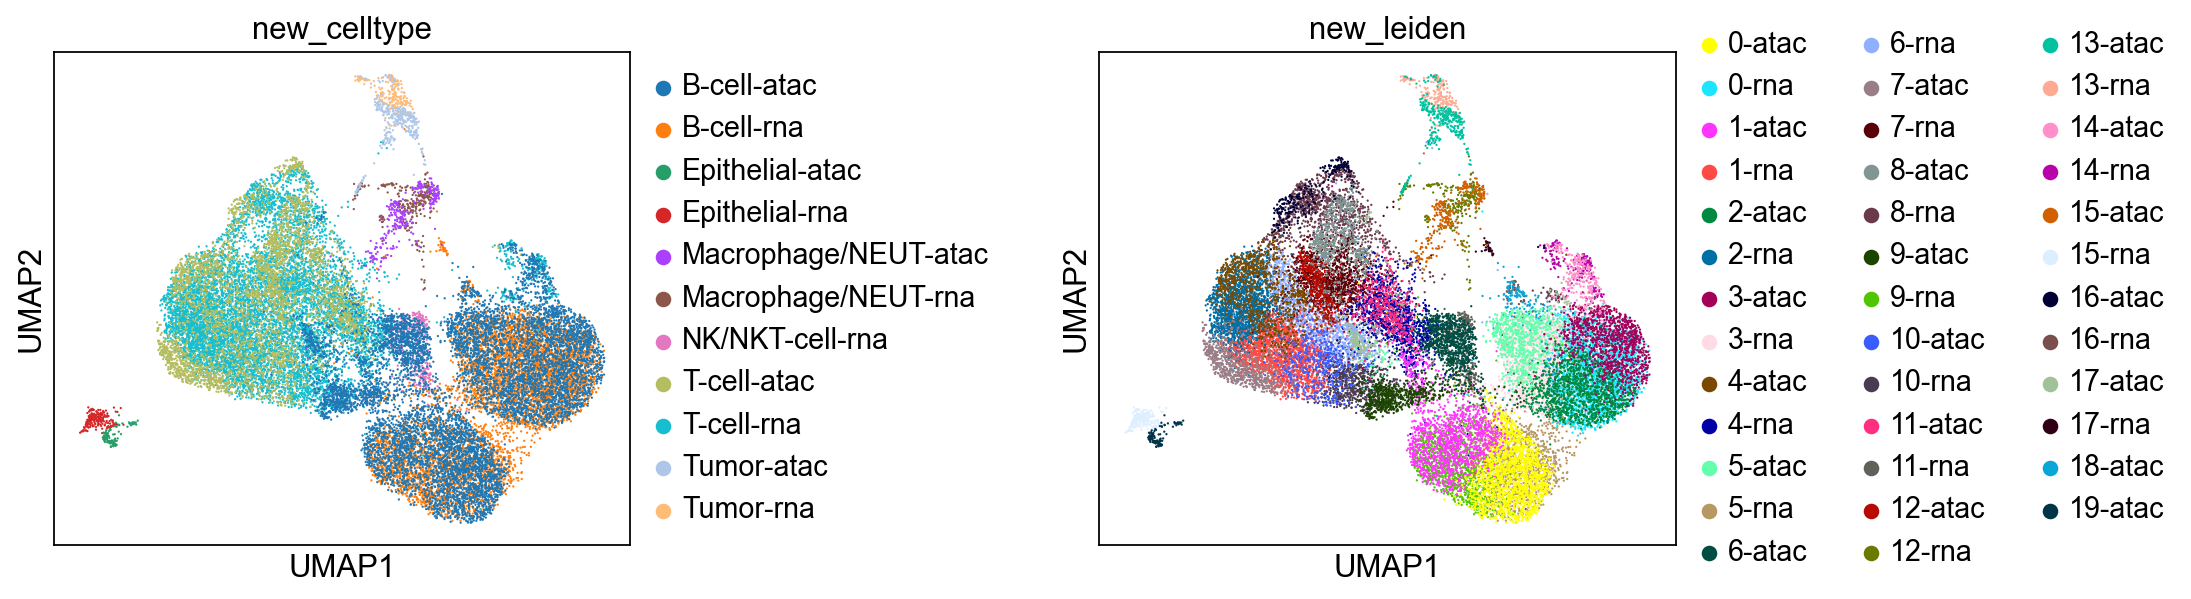

In [62]:
sc.pl.umap(combined, color=["new_celltype","new_leiden"], wspace=0.65)

In [63]:
adata.write_h5ad('atac_act_anno.h5ad',compression='gzip')

In [65]:
atac,adata

(AnnData object with n_obs × n_vars = 12844 × 71272
     obs: 'Type', 'domain'
     var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
     uns: 'Type_colors', 'neighbors', 'umap'
     obsm: 'X_glue', 'X_lsi', 'X_umap'
     varm: 'X_glue'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 12844 × 2839
     obs: 'Type', 'leiden', 'major_celltype', 'domain', 'new_leiden', 'new_celltype'
     var: 'gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'protein_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'Type_colors', 'neighbors', 'umap', 'log1p', 'hvg', 'pca', 'leiden', 'paga', 'leiden_sizes', 'leiden_colors', 'dendrogram_leiden', 'rank_genes_groups', 'major_celltype_colors'
     obsm: 'X_glue', 'X_lsi', 'X_umap', 'X_pca'
     varm: 'PCs'
     obsp: 'connectivities', 'distances')

In [74]:
atac.obs['major_celltype']=adata.obs['major_celltype']
atac.uns['major_celltype_colors']=adata.uns['major_celltype_colors']
atac.obsm['X_umap']=adata.obsm['X_umap']
atac.obsm['X_pca']=adata.obsm['X_pca']

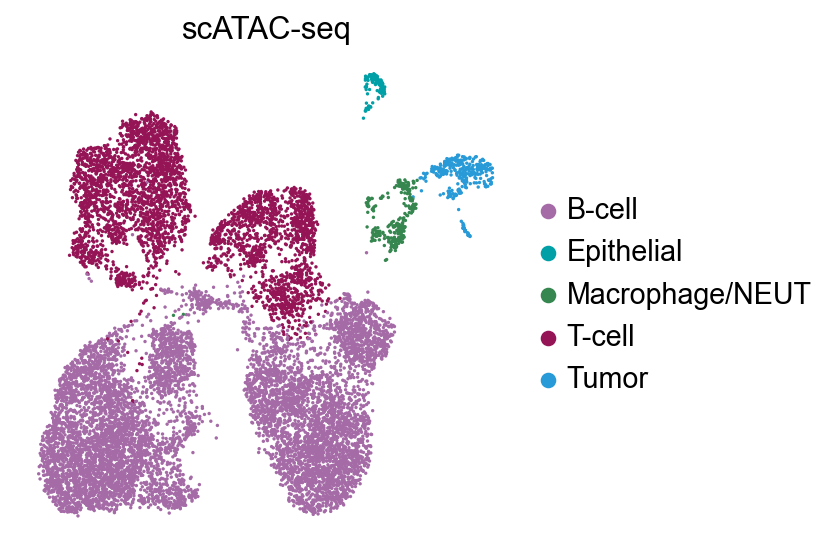

In [75]:
#pp=plt.figure(figsize=(4,4))
#用ax控制图片
#ax=pp.add_subplot(1,1,1)
ax=sc.pl.embedding(
    atac,
    basis="X_umap",
    color='major_celltype',
    title='scATAC-seq',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    show=False,
)
plt.savefig("figure1_celltype_scatac.png",dpi=300,bbox_inches = 'tight')

In [76]:
atac.write_h5ad('atac_anno.h5ad',compression='gzip')